# Introuction 

This code walks through the process of post-processing flowfield data. We work with vorticity data $\omega(x,y,t)$ and begin by _coarse-graining_ by integrating along the $y$-coordinate:
$$ \overline{\omega}(x,t) = \int_{-H}^{+H} \omega(y; x,t) dy $$
Doing so eliminates the $y$-coordinate, compressing the vorticity data $\omega(x,y,t)$ from two dimensions in space to one, and keeping time-periodic behavior.

We then _time-delay embed_ the data, producing $\overline{\omega}_2(x,t)$ by copying the original signal but offsetting its periodic behavior by one-quarter period $\frac{1}{4} \mathcal{T}$. This produces a system of signals $ [ \overline{\omega}_1(x,t)  , \overline{\omega}_2(x,t)  ] $: a pair of equal amplitude, equal frequency periodic signals that are $\frac{\pi}{4}$ out of phase.


In [1]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

# Load modules, parameters, and settings

First we load necessary libraries, then we read the `config.json` file, which sets various parameters for the entire process: flowfield selection, coarse-graining, time-delay embedding, and the model selection.



In [2]:
###  Import modules

import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import os
import datetime
import json

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



###  Load the analysis settings

#  Load the configuration file with all settings
with open('config.json', 'r') as f:
    config = json.load(f)

#  Read out and import all variables
for key, value in config.items():  print(f"{key}: {value}")
globals().update(config)



###  Load the PDE-FIND polynomial libraries

from PDEFIND_Libraries import fnc_PDEFIND_Libraries
library_functions, library_function_names = fnc_PDEFIND_Libraries(PolyPower)




Re: 50
data_choice_string: W
y_CG_1: -8
y_CG_2: 8
TD_Embed: 2
x_trnc_pt_a: 199
x_trnc_pt_b: 2574
threshold: 0
should_interact: 0
should_uniform: 1
should_normalize: 1
is_periodic: 0
deriv_order: 2
PolyPower: 23
should_bias: 0
train_proportion: 0.6
PF_alpha: 1e-05
PF_max_iter: 200


# Load the coarse-grained data

Next we load the coarse-grained data, having already coarse-grained the flowfields in [this previous notebook, here](https://github.com/j-j-williams/CoarseGrained-VortexShedding/blob/156c59f22e49eec4566368007d53af3b48fae2c1/Processing%20Vortex%20Shedding%20Data/Coarse-Grain%20%E2%80%93%20Load%20.NPY%20Files%2C%20Take%20y-Average.ipynb).  

In [3]:
###  Set the loading stem and load the data and parameters


stem = '../Vortex Shedding Data/'


data = np.load( stem + 'Coarse-Grained Flowfield Data/y-avg/Re' + str(Re) + '/' + data_choice_string + '/' + data_choice_string + '_y' + str(y_CG_1) + '_y' + str(y_CG_2) + '.npy' )


x  = np.load( stem + 'Parameters/Re' + str(Re) + '/x.npy' )
t  = np.load( stem + 'Parameters/Re' + str(Re) + '/t.npy' )
dx = np.load( stem + 'Parameters/Re' + str(Re) + '/dx.npy' )[0][0]
dt = np.load( stem + 'Parameters/Re' + str(Re) + '/dt.npy' )[0][0]



# Plot the data

Below we plot a snapshot of the vorticity flowfield $\omega(x,y;t=t_k)$ and its coarse-grained variable $\overline{\omega}(x;t=k)$. Then we plot the entire spatiotemporal $\overline{\omega}(x,t)$ from coarse-graining the time evolution of the vorticity flowfield.

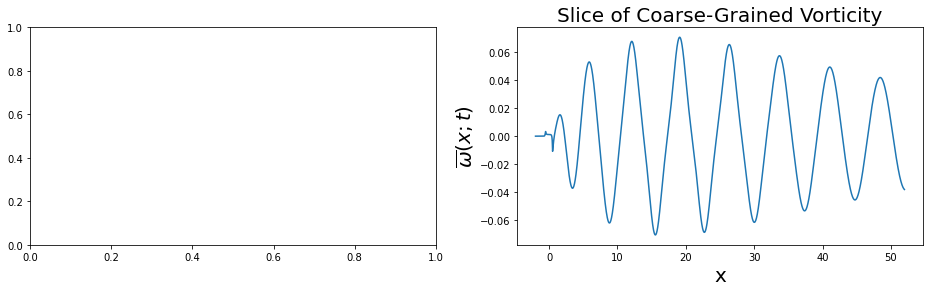

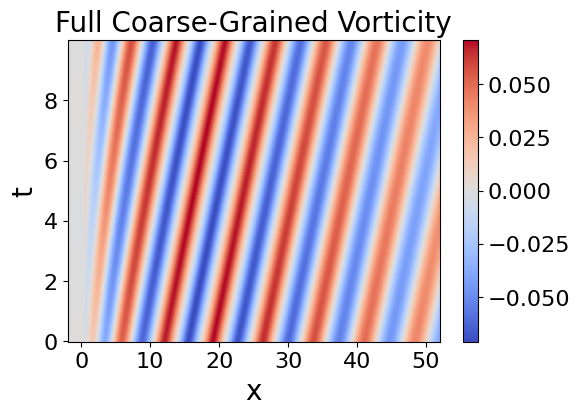

In [4]:
###  Plot the flowfield and coarse-grained data


full_xt_mshgrd , full_tx_mshgrd = np.meshgrid(x[1:-1],t)
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
# plt.pcolormesh(xt_mshgrd, tx_mshgrd, data[].T, cmap='coolwarm' )

# plt.xlabel('x', fontsize=20)
# plt.ylabel('y', fontsize=20)
# ax = plt.gca()
# plt.gca().set_title(r'Vorticity Flowfield at $t=t_n$', fontsize=20)


plt.subplot(1, 2, 2)
plt.plot(x[1:-1], data[:,0].T )

plt.xlabel('x', fontsize=20)
plt.ylabel(r'$\overline{\omega}(x;t)$', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Slice of Coarse-Grained Vorticity', fontsize=20)
# plt.xticks(fontsize=16)
# plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



plt.figure(dpi=100)
plt.pcolormesh(full_xt_mshgrd, full_tx_mshgrd, data[:,:].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Full Coarse-Grained Vorticity', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



# Time-Delay Embed the Data

Next we time-delay embed the data, producing a second spatiotemporal $\overline{\omega}_2(x,t)$ by copying the first signal $\overline{\omega}_2(x,t)$ and offsetting it by one quarter of the period $\tau = \frac{1}{4} \mathcal{T}$. This produces a system $[\overline{\omega}_1,\overline{\omega}_2](x,t)$ of equal amplitude, equal frequency spatiotemporal signals that are periodic and offset by $\frac{\pi}{4}$. 



In [5]:
###  Pre-Process the data


# Normalize the data to min/max = +/- 1
data = data / np.max(np.max( np.abs(data) ))


# Time-Delay Embed
t_1 = t
t_2 = t+TD_Embed
TD_Embed_Index = np.argmin( np.abs(t - TD_Embed) )
TD_Embed_backendIndex = np.argmin( np.abs( t_2 - np.max(t_1) ) ) 

data_1 = data[: , TD_Embed_Index:-1 ]
data_2 = data[: , 0:TD_Embed_backendIndex ]
t_Ovlp = t[TD_Embed_Index:-1]
t_PF = t_Ovlp - t_Ovlp[0]


# Compute time-derivatives of the data
data_1_dt = ps.FiniteDifference(axis=1)._differentiate(data_1   , dt)
data_2_dt = ps.FiniteDifference(axis=1)._differentiate(data_2   , dt)



In [6]:
### Create the truncated space vector


x_PF = x[1+x_trnc_pt_a:1+x_trnc_pt_b+1]
n_X_PF = x_trnc_pt_b - x_trnc_pt_a + 1

print('n_X_PF = ' + str(n_X_PF) )
print('x_a = ' + str(x[1+x_trnc_pt_a]))
print('x_b = ' + str(x[1+x_trnc_pt_b]))



# Create the data and d/dt data matrices for PDE-FIND

u              = np.zeros( ( n_X_PF , len(t_PF), 2) )
u[:, :, 0]     = data_1[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]
u[:, :, 1]     = data_2[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]

u_dot          = np.zeros( ( n_X_PF , len(t_PF), 2) )
u_dot[:, :, 0] = data_1_dt[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]
u_dot[:, :, 1] = data_2_dt[ x_trnc_pt_a:x_trnc_pt_b+1 , : ]





n_X_PF = 2376
x_a = 2.0000000000000036
x_b = 49.50000000000004


# Plot the phase space

The phase space of the systems plots $\overline{\omega}_2$ against $\overline{\omega}_1$. By time-delay embedding with $\tau = \frac{1}{4} \mathcal{T}$, we produce a pair of signals that are maximally independent, tracing out an almost circular path in phase space.



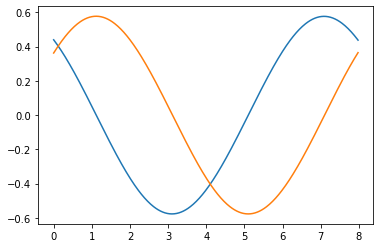

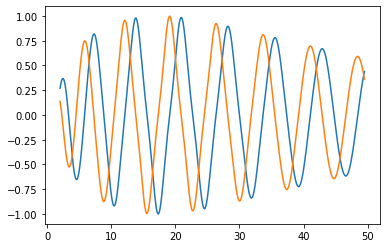

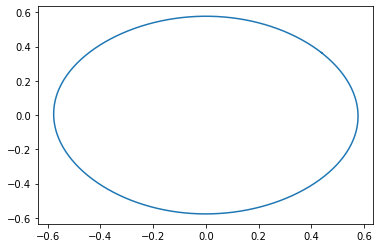

In [31]:

x_plt = -1


plt.figure()

plt.plot(t_PF, u[x_plt,:,0])
plt.plot(t_PF, u[x_plt,:,1])

plt.show()



plt.figure()

plt.plot(x_PF, u[:,0,0])
plt.plot(x_PF, u[:,0,1])

plt.show()



plt.figure()

plt.plot(u[x_plt,:,0], u[x_plt,:,1])

plt.show()




In [7]:
###  Initialize and run PDE-FIND


train = np.random.choice(len(t_PF), int(len(t_PF) * train_proportion), replace=False)
test = [i for i in np.arange(len(t_PF)) if i not in train]
u_train = u[:, train, :]
u_test = u[:, test, :]
u_dot_train = u_dot[:, train, :]
u_dot_test = u_dot[:, test, :]
t_train = t_PF[train]
t_test = t_PF[test]


spatial_grid = np.asarray([x_PF]).T


###  Derivatives turned on and spatial grid included
pde_lib = ps.PDELibrary(
    library_functions   = library_functions,
    function_names      = library_function_names,
    derivative_order    = deriv_order,
    spatial_grid        = spatial_grid,
    include_bias        = should_bias,
    include_interaction = should_interact,
    is_uniform          = should_uniform,
    periodic            = is_periodic
)

optimizer = ps.STLSQ(
    threshold         = threshold, 
    alpha             = PF_alpha,
    normalize_columns = should_normalize, 
    max_iter          = PF_max_iter
)


model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=["u", "v"])
model.fit(u_train, x_dot=u_dot_train )


u_dot_stlsq_train = model.predict(u_train)
u_dot_stlsq_test  = model.predict(u_test)
u_dot_stlsq_total = model.predict(u)



In [8]:
### Compute errors


u_dot_train_err = u_dot_train - u_dot_stlsq_train
u_dot_test_err  = u_dot_test  - u_dot_stlsq_test
u_dot_total_err = u_dot       - u_dot_stlsq_total

NRMSE_train = np.sqrt( np.sum( np.sum( u_dot_train_err**2 , axis=0 ) , axis=0) / np.sum( np.sum( u_dot_train**2 , axis=0 ) , axis=0) )
NRMSE_test  = np.sqrt( np.sum( np.sum( u_dot_test_err**2 , axis=0 ) , axis=0)  / np.sum( np.sum( u_dot_test**2  , axis=0 ) , axis=0) )
NRMSE_total = np.sqrt( np.sum( np.sum( u_dot_total_err**2 , axis=0 ) , axis=0) / np.sum( np.sum( u_dot**2       , axis=0 ) , axis=0) )

NRMSE_train_sys = np.sqrt( np.sum( NRMSE_train**2 ) )
NRMSE_test_sys  = np.sqrt( np.sum( NRMSE_test**2  ) )
NRMSE_total_sys = np.sqrt( np.sum( NRMSE_total**2 ) )




In [9]:
###  Compute  score


score_test = model.score(u_test, t=t_test)
# score_train = model.score(u_train, t=np.sort(t_train) )



In [10]:
###  Post-processing for writing these coefficients out later

Coefs_u1 = model.coefficients()[0 , :]
Coefs_u2 = model.coefficients()[1 , :]


In [11]:
###  Print all info regarding generated sparse model from PDE-FIND!!


print('\nx_a = ' + str(x[1+x_trnc_pt_a]))
print('x_b = ' + str(x[1+x_trnc_pt_b])+'\n')


print('Sparsity threshold = ' + str(threshold) + '\n')


print('Library terms:')
print(pde_lib.get_feature_names())
print('\n\n')


print('STLSQ model: ')
model.print(precision=10)
# model.print(precision=4)


print('\n\n***** Normalized Room Mean Square Errors (NRMSE)\n')
print('(u1, u2) Training Set NRMSE = ( ' + str(NRMSE_train[0]) + ' , '   + str(NRMSE_train[1]) + ' )' )
print('(u1, u2) Testing  Set NRMSE = ( ' + str(NRMSE_test[0])  + ' , '   + str(NRMSE_test[1])  + ' )' )
print('(u1, u2) Total    Set NRMSE = ( ' + str(NRMSE_total[0]) + ' , '   + str(NRMSE_total[1]) + ' )' + '\n' )

print('System Training NRMSE = ' + str(NRMSE_train_sys) )
print('System Testing  NRMSE = ' + str(NRMSE_test_sys)  )
print('System Total    NRMSE = ' + str(NRMSE_total_sys) )

print('\n\n')

print('Test Score is  =  ' + str(score_test) + '\n\n' )





x_a = 2.0000000000000036
x_b = 49.50000000000004

Sparsity threshold = 0

Library terms:
['x0', 'x1', 'x0x0', 'x1x1', 'x0x1', 'x0x0x0', 'x1x1x1', 'x0x0x1', 'x0x1x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11']



STLSQ model: 
(u)' = -0.0307511628 u + -0.4996139554 v + -0.0000120166 uu + 0.0000034731 vv + -0.0000018947 uv + 0.0162373210 uuu + -0.0062367342 vvv + 0.0795575928 uuv + 0.0365687407 uvv + -0.5379527193 u_1 + -0.0094590521 v_1 + -0.0102486787 u_11 + -0.2303969637 v_11
(v)' = 0.4983670661 u + -0.0230033230 v + 0.0000057205 uu + -0.0000055350 vv + -0.0000380250 uv + 0.0070808974 uuu + 0.0145433703 vvv + 0.0328375064 uuv + -0.0779898577 uvv + 0.0048334543 u_1 + -0.5395966178 v_1 + 0.2307688116 u_11 + -0.0101521451 v_11


***** Normalized Room Mean Square Errors (NRMSE)

(u1, u2) Training Set NRMSE = ( 0.022418004768382613 , 0.0222680646006763 )
(u1, u2) Testing  Set NRMSE = ( 0.022429305654627685 , 0.02226023212166596 )
(u1, u2) Total    Set NRMSE = ( 0.022422526911344037 , 0.02226493230

In [12]:
###  fodder

###  jump here  for results (crtl-f 'jump')


In [13]:
###  Build the meshes for colorplots

xt_mshgrd, tx_mshgrd = np.meshgrid(x_PF , t_PF)


###  Set plotting points in space (x) and time (t)

tplt = 0
xplt = -1



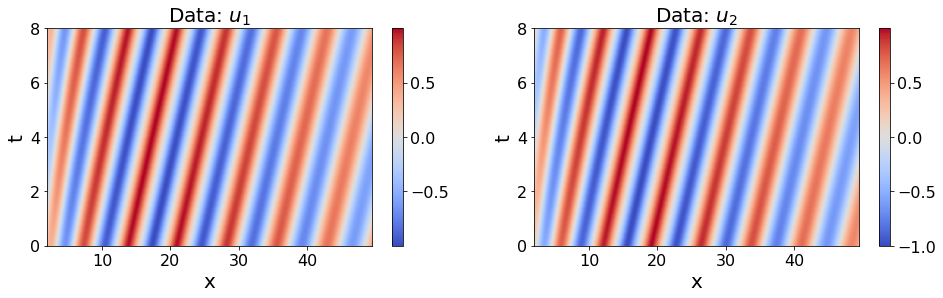

In [14]:
### Colorplots of the  data

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,0].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,1].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



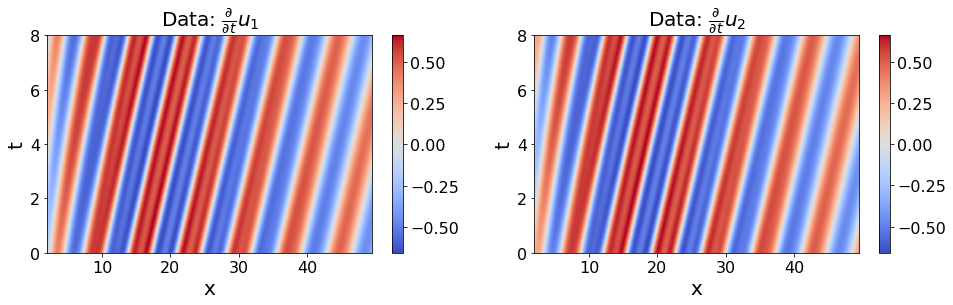

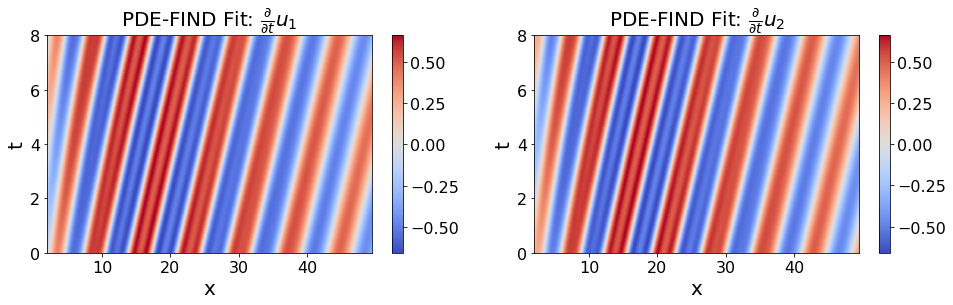

In [15]:
### Colorplots of the  (d/dt  data)

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot[:,:,0].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $\frac{\partial }{\partial t} u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot[:,:,1].T, cmap='coolwarm' )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'Data: $\frac{\partial }{\partial t} u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



### Colorplots of PDE-FIND fit

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_stlsq_total[:,:,0].T, cmap='coolwarm', vmin=np.min(np.min(u_dot[:,:,0]) ), vmax=np.max(np.max(u_dot[:,:,0]) ) )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'PDE-FIND Fit: $\frac{\partial }{\partial t} u_1$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_stlsq_total[:,:,1].T, cmap='coolwarm', vmin=np.min(np.min(u_dot[:,:,1]) ), vmax=np.max(np.max(u_dot[:,:,1]) ) )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'PDE-FIND Fit: $\frac{\partial }{\partial t} u_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



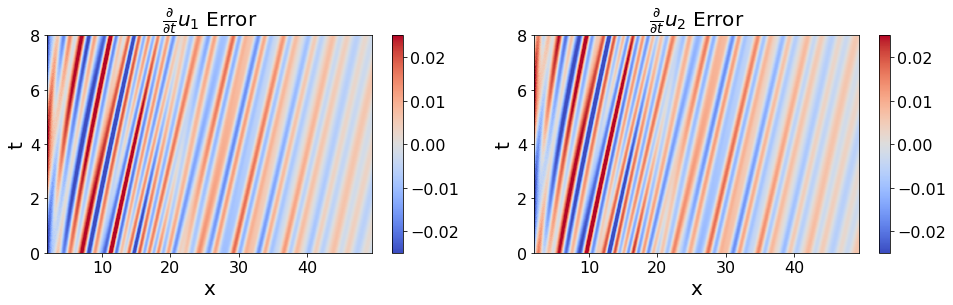

In [16]:
### Colorplots of the error


# vminmax = 0.0125
vminmax = 0.025


## Plots

plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_total_err[:,:,0].T, cmap='coolwarm' , vmin = -vminmax , vmax = vminmax )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'$\frac{\partial }{\partial t} u_1$ Error', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)


plt.subplot(1, 2, 2)
plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_total_err[:,:,1].T, cmap='coolwarm' , vmin = -vminmax , vmax = vminmax )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
ax = plt.gca()
plt.gca().set_title(r'$\frac{\partial }{\partial t} u_2$ Error', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)

plt.show()



In [17]:
tplt = 50

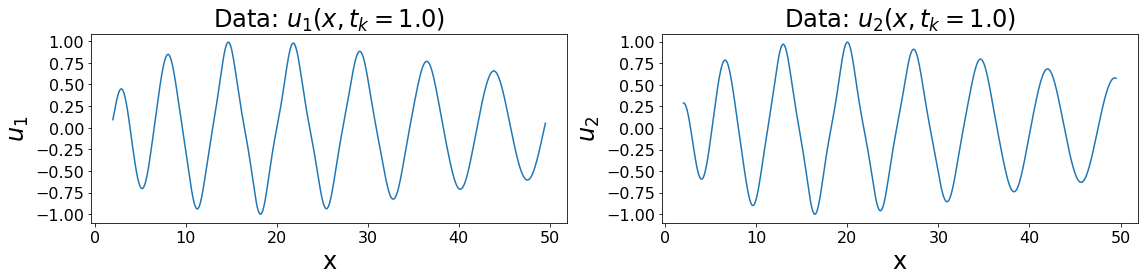

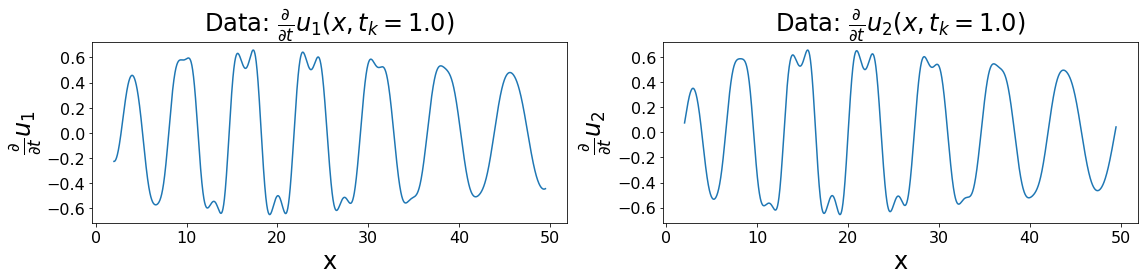

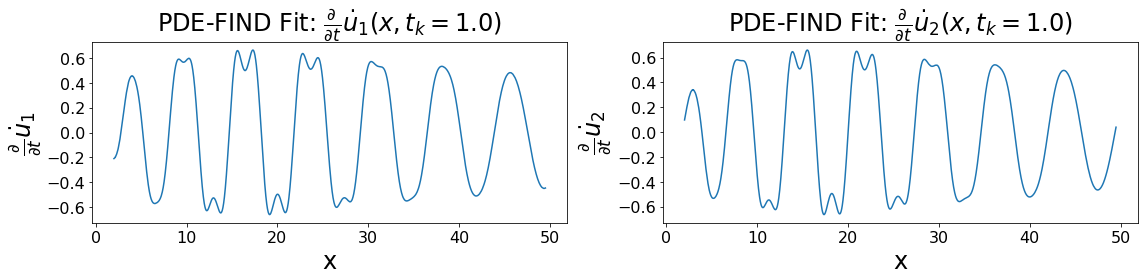

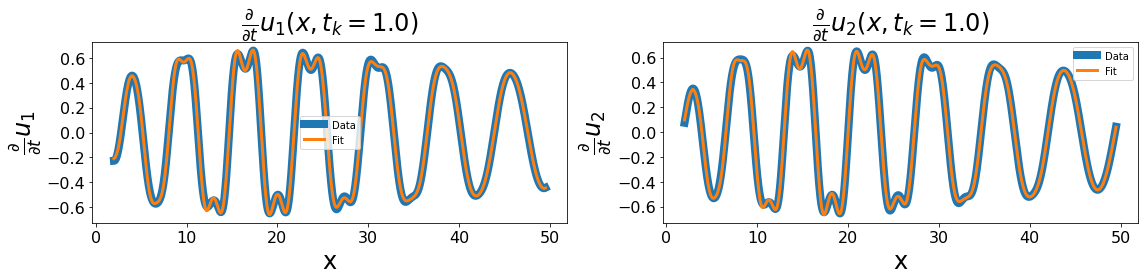

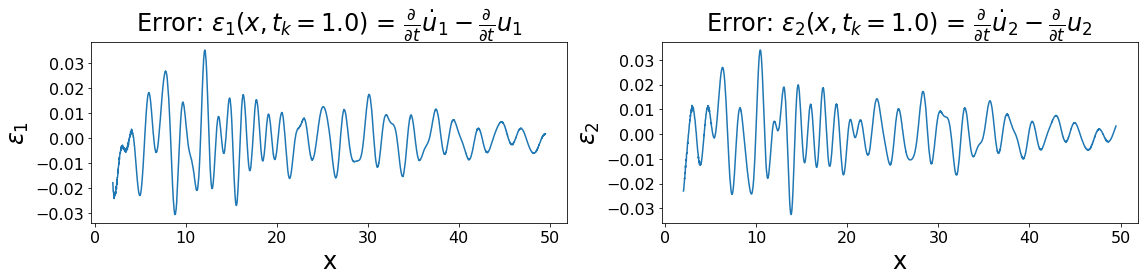

In [18]:
###  Line plots of  slices of time  at  t = t_k




###


plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$u_1$', fontsize=24)
ttl_str = r'Data: $u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$u_2$', fontsize=24)
ttl_str = r'Data: $u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()






plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data: $\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data: $\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()






plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u}_1$', fontsize=24)
ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u}_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u}_2$', fontsize=24)
ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u}_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



plt.tight_layout()
plt.show()



plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.plot( x_PF , u_dot[:,tplt,0] , label='Data' , linewidth = 8)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0] , label='Fit' , linewidth = 3)


plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()


plt.subplot(1, 2, 2)

plt.plot( x_PF , u_dot[:,tplt,1] , label='Data' , linewidth = 8)
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1] , label='Fit' , linewidth = 3)


plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()


plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot_total_err[:,tplt,0])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\epsilon_1$', fontsize=24)
ttl_str = r'Error: $\epsilon_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + r') = $\frac{\partial}{\partial t}\dot{u}_1 - \frac{\partial}{\partial t}u_1$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot_total_err[:,tplt,1])
plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\epsilon_2$', fontsize=24)
ttl_str = r'Error: $\epsilon_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + r') = $\frac{\partial}{\partial t}\dot{u}_2 - \frac{\partial}{\partial t}u_2$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.show()




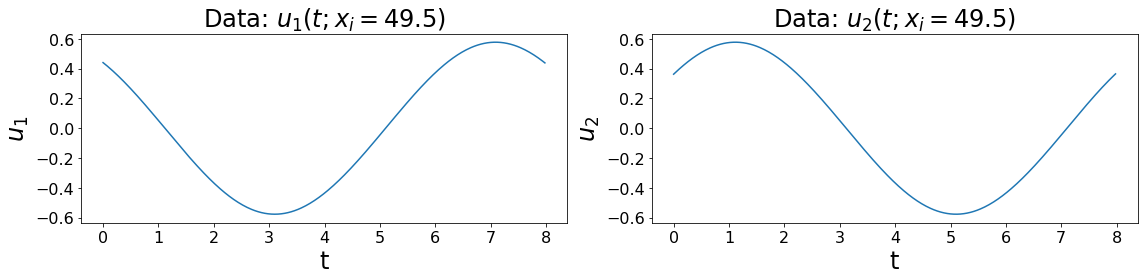

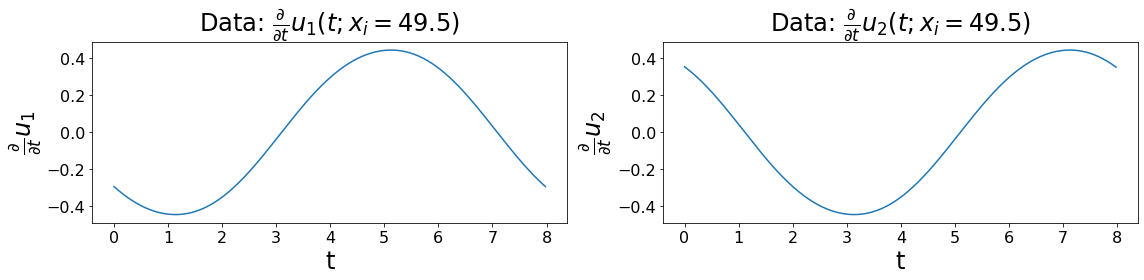

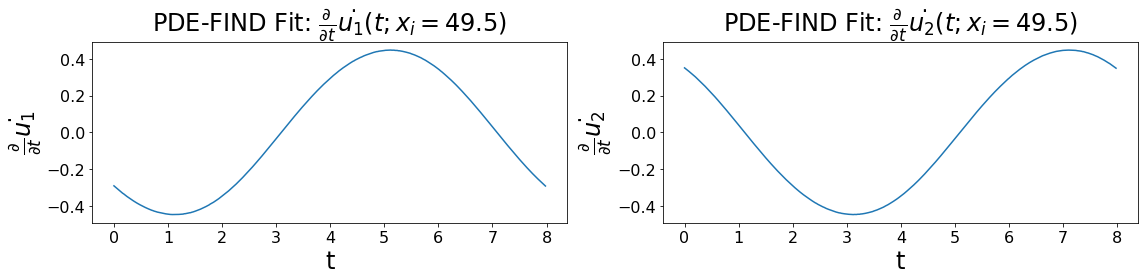

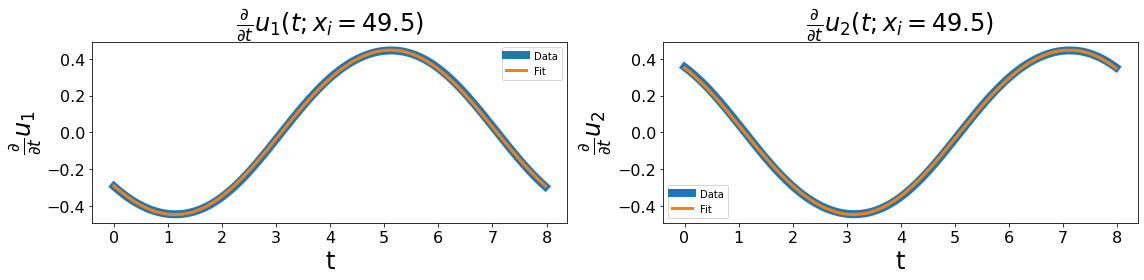

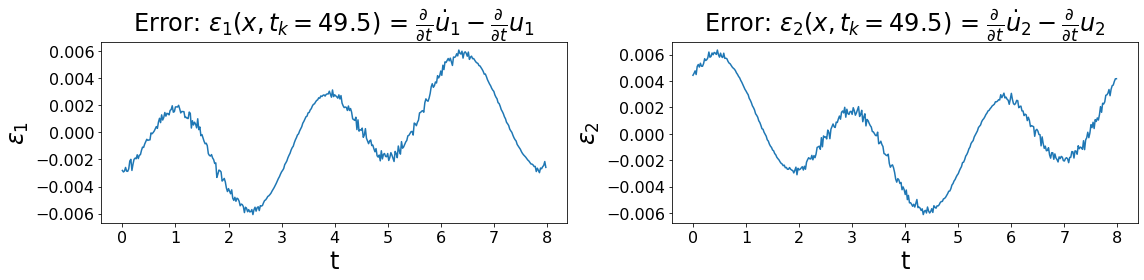

In [19]:
###  Line plots of  slices of space  at  x = x_i




###  


plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$u_1$', fontsize=24)
ttl_str = r'Data: $u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$u_2$', fontsize=24)
ttl_str = r'Data: $u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()




plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)

ttl_str = r'Data: $\frac{\partial}{\partial t}u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)

ttl_str = r'Data: $\frac{\partial}{\partial t}u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u_1}$', fontsize=24)

ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u_1} (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}\dot{u_2}$', fontsize=24)

ttl_str = r'PDE-FIND Fit: $\frac{\partial}{\partial t}\dot{u_2} (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



plt.tight_layout()
plt.show()




plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.plot( t_PF , u_dot[xplt,:,0] , label='Data' , linewidth = 8)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0] , label='Fit' , linewidth = 3)


plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_1 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()



plt.subplot(1, 2, 2)

plt.plot( t_PF , u_dot[xplt,:,1] , label='Data' , linewidth = 8)
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1] , label='Fit' , linewidth = 3)


plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'$\frac{\partial}{\partial t}u_2 (t ; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()



plt.tight_layout()
plt.show()










plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot_total_err[xplt,:,0])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\epsilon_1$', fontsize=24)
ttl_str = r'Error: $\epsilon_1 (x, t_k = $' + str( np.round(x_PF[xplt],2) )  + r') = $\frac{\partial}{\partial t}\dot{u}_1 - \frac{\partial}{\partial t}u_1$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot_total_err[xplt,:,1])
plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\epsilon_2$', fontsize=24)
ttl_str = r'Error: $\epsilon_2 (x, t_k = $' + str( np.round(x_PF[xplt],2) )  + r') = $\frac{\partial}{\partial t}\dot{u}_2 - \frac{\partial}{\partial t}u_2$'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.show()






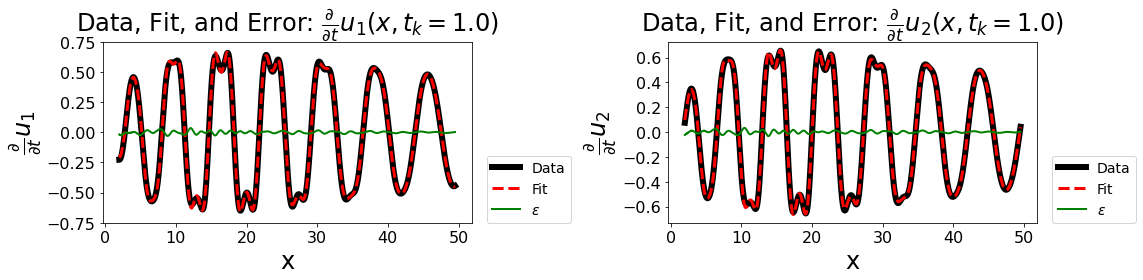

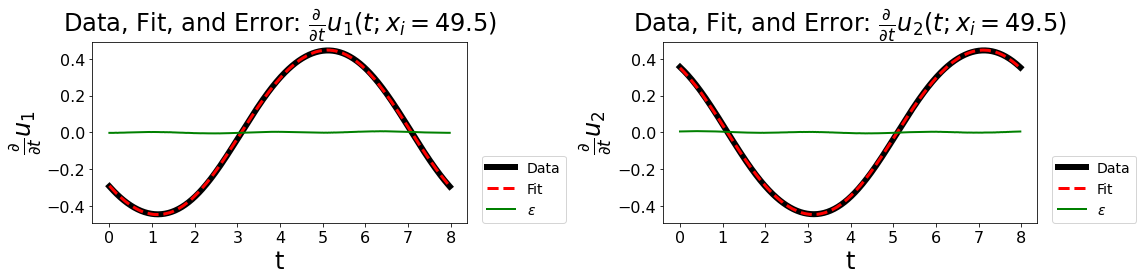

In [20]:
### Plot slices and errors together


plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.plot( x_PF , u_dot[:,tplt,0]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( x_PF , u_dot_total_err[:,tplt,0]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_1 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks([-0.75,-0.5,-0.25,0,0.25,0.5,0.75],fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)

plt.subplot(1, 2, 2)
plt.plot( x_PF , u_dot[:,tplt,1]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,1] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( x_PF , u_dot_total_err[:,tplt,1]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_2 (x, t_k = $' + str( np.round(t_PF[tplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)


plt.tight_layout()
plt.show()





plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.plot( t_PF , u_dot[xplt,:,0]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,0] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( t_PF , u_dot_total_err[xplt,:,0]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_1$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_1 (t; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)

plt.subplot(1, 2, 2)
plt.plot( t_PF , u_dot[xplt,:,1]           , 'k-'  , linewidth = 6 , label='Data' , )
plt.plot( t_PF , u_dot_stlsq_total[xplt,:,1] , 'r--' , linewidth = 3 , label='Fit')
plt.plot( t_PF , u_dot_total_err[xplt,:,1]   , 'g-' ,  linewidth = 2 , label='$\epsilon$')

plt.xlabel('t', fontsize=24)
plt.ylabel(r'$\frac{\partial}{\partial t}u_2$', fontsize=24)
ttl_str = r'Data, Fit, and Error: $\frac{\partial}{\partial t}u_2 (t; x_i = $' + str( np.round(x_PF[xplt],2) ) + ')'
plt.title(ttl_str, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend( loc=(1.04, 0) , fontsize=14)


plt.tight_layout()
plt.show()




# Normal form parameters

The normal form parameters $(\sigma, \beta)$ are a transformation of the fitted model.

In [22]:
###  Compute the normal form parameters


from Compute_NormalFormParameters import fnc_Compute_NormalFormParameters
NF_sigma, NF_beta = fnc_Compute_NormalFormParameters(model.feature_library, model.optimizer)




Value of ANS_a  =  [0.08086283]


( 1st , 2nd )  Value of Beta  =  ( -0.06154984752631875 , -0.04615738995102657 )

Avg Value of Beta  =  -0.05385361873867266





In [25]:
###  data dump:  Write out file with all parameters, computables ... 


datetime.date.today().strftime("%B %d, %Y")
datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

str_datetime = datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
# save_path = '../x_'+str(np.round(x[1+x_trnc_pt_a],1))+'_'+str(np.round(x[1+x_trnc_pt_b],1))
save_path = '../Results/'  + str_datetime + '__Re' + str(Re) + '_' + data_choice_string+ '_y' + str(y_CG_1) + '_y' + str(y_CG_2) +'_x' + str(np.round(x[1+x_trnc_pt_a],1)) + '_x' + str(np.round(x[1+x_trnc_pt_b],1)) + '_TD' + str(TD_Embed)
os.mkdir(save_path)


# save_path
# save_path +'/readme.txt', 'w'

with open(save_path +'/readme.txt', 'w') as f:
#     f.write( Video_Load_String )
    
#     f.write( '\n\n\n  Number of frames =  ' + str(video_length) )
#     f.write( '\n  FPS =  ' + str(fps) )
#     f.write( '\n  Precise length =  ' + str(precise_time_length) + ' sec\n\n' )

#     f.write( '\n  Frame increment (subsampling) =  ' + str(frame_increment) )
    
    
    f.write( '\nRe                    =   ' + str(Re) + '\n')
    f.write( '\nData                  =   ' + data_choice_string + '\n')
    f.write( '\nTime-Delay Embedding  =   ' + str(TD_Embed) + '\n\n')
    
    f.write( '\nCoarse-Graining Interval: ' + str(y_CG_1) + '  <=  y  <=  ' + str(y_CG_2) + '\n\n')


    f.write( '\nx_a = ' + str(x[1+x_trnc_pt_a]) )
    f.write( '\nx_b = ' + str(x[1+x_trnc_pt_b])+'\n' )
    f.write( '\n\n' )
    
    f.write( '\nSparsity threshold   =   ' + str(threshold)        + '\n' )
    f.write( '\nTraining proportion  =   ' + str(train_proportion) + '\n'  )

    
    f.write( '\n\nLibrary terms:' )
    f.write( '\n' + str( pde_lib.get_feature_names() ) )
    f.write( '\n\n' )

    
    f.write( '\n\nSTLSQ model: ' )
    f.write( '\n\n' + str(Coefs_u1) )
    f.write( '\n\n' + str(Coefs_u2) + '\n\n\n')
    
    
    f.write('\n\n***** Normalized Room Mean Square Errors (NRMSE)\n\n\n')
    f.write('(u1, u2) Training Set NRMSE = ( ' + str(NRMSE_train[0]) + ' , '   + str(NRMSE_train[1]) + ' )'  + '\n' )
    f.write('(u1, u2) Testing  Set NRMSE = ( ' + str(NRMSE_test[0])  + ' , '   + str(NRMSE_test[1])  + ' )'  + '\n' )
    f.write('(u1, u2) Total    Set NRMSE = ( ' + str(NRMSE_total[0]) + ' , '   + str(NRMSE_total[1]) + ' )' + '\n\n\n' )

    f.write('System Training NRMSE = ' + str(NRMSE_train_sys)  + '\n' )
    f.write('System Testing  NRMSE = ' + str(NRMSE_test_sys)   + '\n' )
    f.write('System Total    NRMSE = ' + str(NRMSE_total_sys)  + '\n\n\n' )


    f.write('Test Score is  =  ' + str(score_test) + '\n\n' )


    
    
    f.write( '\n\n\n\n' )
    
    

    f.write( 'First Lyapunov coefficient l_1(0)     =  ' + str( ANS_a_2[0] )  )
    
    f.write( '\n\n' )
    
    
    
    f.write( 'Value of beta for normal form         =  ' + str( Beta_hopf_avg )  )
    
    
    f.write( '\n\n' )

# Anything else?

print('\n**************')
print('\n  Finished!!  ')
print('\n**************')



NameError: name 'ANS_a_2' is not defined

x[949]



t_plt = 200


plt.figure()

plt.plot( x[1:-1] , data[:,t_plt] , )

plt.xlabel(r'$x$' , fontsize=20 ) 
plt.ylabel(r'$\overline{\omega} \, (x ; t = 0)$' , fontsize=20 )


plt.xticks( fontsize=16 )
plt.yticks( [ -1 , -0.5 , 0 , 0.5 , 1 ] , fontsize=16 )



plt.show()



np.shape(t)


full_xt_mshgrd, full_tx_mshgrd = np.meshgrid(x[1:-1] , t)



fig, ax = plt.subplots()


cax = plt.pcolormesh(full_xt_mshgrd, full_tx_mshgrd, data.T, cmap='coolwarm' , vmin = -1 , vmax = 1 )


cbar = fig.colorbar(cax, ticks=[ -1 , -0.5 , 0 , 0.5 , 1 ] )
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\overline{\omega} \, (x, t)$' , fontsize=16)

plt.xlabel('$x$', fontsize=20)
plt.ylabel('$t$', fontsize=20)


plt.xticks(              fontsize=16)
plt.yticks([0,2,4,6,8] , fontsize=16)


plt.show()




fig, ax = plt.subplots()


cax = plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,0].T, cmap='coolwarm' , vmin = -1 , vmax = 1 )


cbar = fig.colorbar(cax, ticks=[ -1 , -0.5 , 0 , 0.5 , 1 ] )
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\overline{\omega}_1 \, (x, t)$' , fontsize=16)

plt.xlabel('$x$', fontsize=20)
plt.ylabel('$t$', fontsize=20)


plt.xticks(              fontsize=16)
plt.yticks([0,2,4,6,8] , fontsize=16)


plt.show()



np.shape(u[:,:,0].T)



x_plt = 0


plt.figure()

plt.plot( t_PF , u[x_plt,:,0] , )




plt.show()



t_plt = 200


plt.figure()

plt.plot( x_PF , u[:,t_plt,0] , label=r'$\overline{\omega}_1$' )
plt.plot( x_PF , u[:,t_plt,1] , label=r'$\overline{\omega}_2$' )

plt.xlabel(r'$x$' , fontsize=20 ) 
plt.ylabel(r'$\overline{\omega} \, (x ; t = 0)$' , fontsize=20 )


plt.xticks( fontsize=16 )
plt.yticks( [ -1 , -0.5 , 0 , 0.5 , 1 ] , fontsize=16 )

plt.legend(fontsize=16 , loc='lower right' )

plt.show()



t_plt = 200


plt.figure()

plt.plot( x_PF , u_dot[:,t_plt,0] , label=r'$\frac{\partial}{\partial t} \, \overline{\omega}_1$' )
plt.plot( x_PF , u_dot[:,t_plt,1] , label=r'$\frac{\partial}{\partial t} \, \overline{\omega}_2$' )

# plt.plot( x_PF , u[:,t_plt,0] , label=r'$\overline{\omega}_1$' )
# plt.plot( x_PF , u[:,t_plt,1] , label=r'$\overline{\omega}_2$' )

plt.xlabel(r'$x$' , fontsize=20 ) 
plt.ylabel(r'$\frac{\partial}{\partial t} \, \overline{\omega} \, (x ; t = 0)$' , fontsize=20 )


plt.xticks( fontsize=16 )
plt.yticks( [ -1 , -0.5 , 0 , 0.5 , 1 ] , fontsize=16 )

plt.legend(fontsize=16 , loc='lower right' )


plt.show()





plt.figure(dpi=125)

plt.plot( x_PF , u_dot[:,tplt,0]             , 'c-'  , linewidth = 6 , label=r'$u_t$' , )
plt.plot( x_PF , u_dot_stlsq_total[:,tplt,0] , 'k--' , linewidth = 3 , label=r'$\hat{u_t}$')
plt.plot( x_PF , u_dot_total_err[:,tplt,0]   , 'r-' ,  linewidth = 2 , label=r'$\epsilon$')

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\frac{\partial}{\partial t}u(x;t = '+str(t_PF[tplt])+')$', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks([-0.75,-0.5,-0.25,0,0.25,0.5,0.75],fontsize=14)

plt.legend( loc=(1.04, 0) , fontsize=14)

plt.show()







vminmax_param = 0.75

fig, ax = plt.subplots(dpi=125)


cax = plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot[:,:,0].T, cmap='coolwarm' , vmin = -vminmax_param , vmax = vminmax_param )


cbar = fig.colorbar(cax, ticks=[ -1 , -0.5 , 0 , 0.5 , 1 ] )
cbar.ax.tick_params(labelsize=14)
# cbar.set_label(label=r'$\frac{\partial}{\partial t} \, \overline{\omega}_1 \, (x, t)$' , fontsize=16)
cbar.set_label(label=r'$\frac{\partial}{\partial t} \, u \, (x, t)$' , fontsize=16)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$t$', fontsize=16)


plt.xticks(              fontsize=14)
plt.yticks([0,2,4,6,8] , fontsize=14)


plt.show()




vminmax = 0.025

fig, ax = plt.subplots(dpi=125)
cax = plt.pcolormesh(xt_mshgrd, tx_mshgrd, u_dot_total_err[:,:,0].T, cmap='coolwarm' , vmin = -vminmax , vmax = vminmax )



cbar = fig.colorbar(cax, ticks=[ 0.025 , 0.0125 , 0 , -0.0125 , -0.025 ] )
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label=r'$\epsilon$' , fontsize=16)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$t$', fontsize=16)


plt.xticks(              fontsize=14)
plt.yticks([0,2,4,6,8] , fontsize=14)

plt.show()






np.argmax( u_dot_total_err[1200:,0,0] )

np.shape(u_dot_total_err)

x_PF[1200+155]


vminmax_param = 1

fig, ax = plt.subplots(dpi=200)


cax = plt.pcolormesh(xt_mshgrd, tx_mshgrd, u[:,:,0].T, cmap='coolwarm' , vmin = -vminmax_param , vmax = vminmax_param )


cbar = fig.colorbar(cax, ticks=[ -1 , -0.5 , 0 , 0.5 , 1 ] )
cbar.ax.tick_params(labelsize=8)
# cbar.set_label(label=r'$\frac{\partial}{\partial t} \, \overline{\omega}_1 \, (x, t)$' , fontsize=16)
# cbar.set_label(label=r'$u \, (x, t), v \, (x, t)$' , fontsize=10)

cbar.set_label(label=r'$u , v \, (x, t) $' , fontsize=10)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$t$', fontsize=16)

plt.title('$v(x,t)$' , fontsize=16)


plt.xticks(              fontsize=14)
plt.yticks([0,2,4,6,8] , fontsize=14)


plt.show()

